<a href="https://colab.research.google.com/github/pedromazim/visao/blob/main/visao_histograma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as pt

In [ ]:
from numba import jit

In [ ]:
@jit(nopython=True, looplift=True)
def make_gray(img, weights):

    '''
    converts an colored RGB image to grayscale

    img : image to be converted
    weights : list or array containing the relative weights of red, blue and green for conversion

    '''

    if len(img.shape) == 3:

        img_recol = np.zeros((img.shape[0],img.shape[1]))

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                    img_recol[i,j] = weights[0]*img[i,j,0] + weights[1]*img[i,j,1] + weights[2]*img[i,j,2]

        return img_recol
    else:
        return img

In [ ]:
def histogram(img):

    '''
    returns the histogram of a grayscale image

    img: input image
    '''

    bins = np.arange(256)
    counts = np.zeros_like(bins)

    for b in bins:
        counts[b] = np.where(img==b)[0].size

    return counts

In [ ]:
def cdf_histogram(img):

    '''
    returns the cummulative histogram of a grayscale image

    img: input image
    '''

    bins = np.arange(256)
    counts = histogram(img)
    cdf_counts = np.zeros_like(counts)

    for b in bins:
        cdf_counts[b] = np.sum(counts[0:b])/(img.size)

    return cdf_counts

### Expandindo e comprimindo imagens a partir da an√°lise de histograma

In [ ]:
img = io.imread('https://github.com/pedromazim/visao/blob/main/images/Unequalized_Hawkes_Bay_NZ.jpg?raw=true')
img3 = io.imread('https://github.com/pedromazim/visao/blob/main/images/Image_processing_pre_otsus_algorithm.jpg?raw=true')

In [ ]:
img = make_gray(img, [1/3,1/3,1/3])
img3 = make_gray(img3, [1/3,1/3,1/3])

(-0.5, 1023.5, 682.5, -0.5)

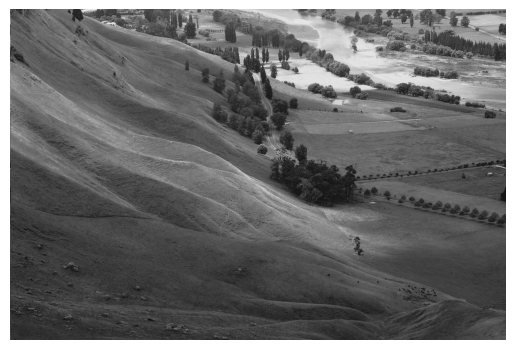

In [ ]:
pt.imshow(img, cmap='gray')
pt.axis('off')

(0.0, 255.0)

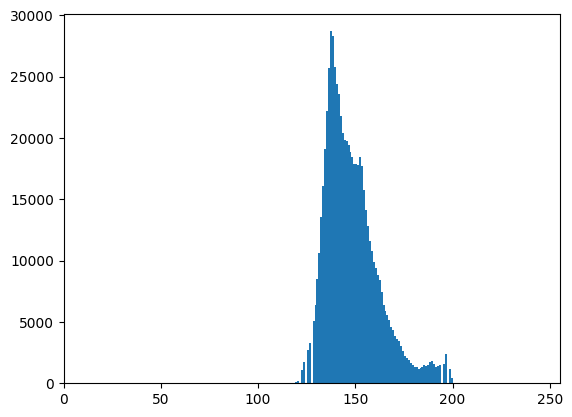

In [ ]:
counts = histogram(img)
cdf_counts = cdf_histogram(img)
pt.stairs(counts, fill=True)
pt.xlim(0,255)

In [ ]:
@jit(nopython=True, looplift=True)
def extend_img(img, counts):

    img_ext = np.copy(img)
    aux = 0

    for c in range(int(np.mean(np.where(counts!=0)[0])),np.where(counts!=0)[0][0]-1,-1):
        for px in np.argwhere(img==c):
            img_ext[px[0],px[1]] = int(c-aux)
        aux+=1
    aux = 0

    for c in range(int(np.mean(np.where(counts!=0)[0])),np.where(counts!=0)[0][-1]+1,1):
        for px in np.argwhere(img==c):
            img_ext[px[0],px[1]] = int(c+aux)
        aux +=1

    return img_ext

In [ ]:
img_ext = extend_img(img,counts)

In [ ]:
counts_ext= histogram(img_ext)

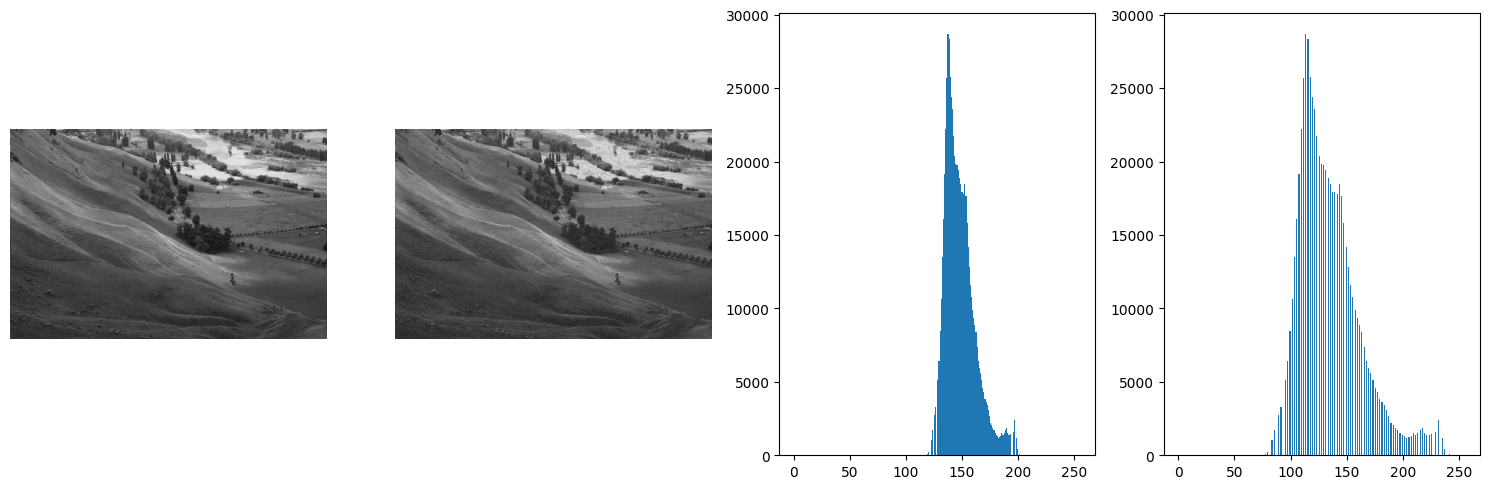

In [ ]:
fig, ax = pt.subplots(1,4, figsize=(15,5))
ax[0].imshow(img, cmap='gray')
ax[0].axis('off')
ax[1].imshow(img_ext, cmap='gray')
ax[1].axis('off')
ax[2].stairs(counts, fill=True)
ax[3].stairs(counts_ext, fill=True)
fig.tight_layout()

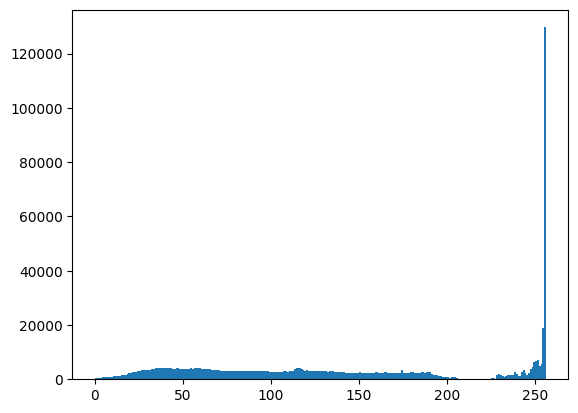

In [ ]:
counts = histogram(img3)
pt.stairs(counts, fill=True)

In [ ]:
@jit(nopython=True, looplift=True)
def compress_img(img, counts):
    img_comp = np.copy(img)
    aux = 50
    for c in range(int(np.mean(np.where(counts!=0)[0])),np.where(counts!=0)[0][0]-1,-1):
        #if int(c+aux) >= int(np.mean(np.where(counts!=0)[0])
        for px in np.argwhere(img==c):
            img_comp[px[0],px[1]] = int(c+aux)
    for c in range(int(np.mean(np.where(counts!=0)[0])),np.where(counts!=0)[0][-1]+1,1):
        for px in np.argwhere(img==c):
            img_comp[px[0],px[1]] = int(c-aux)
    return img_comp

In [ ]:
img_comp = compress_img(img3,counts)
counts_comp = histogram(img_comp)

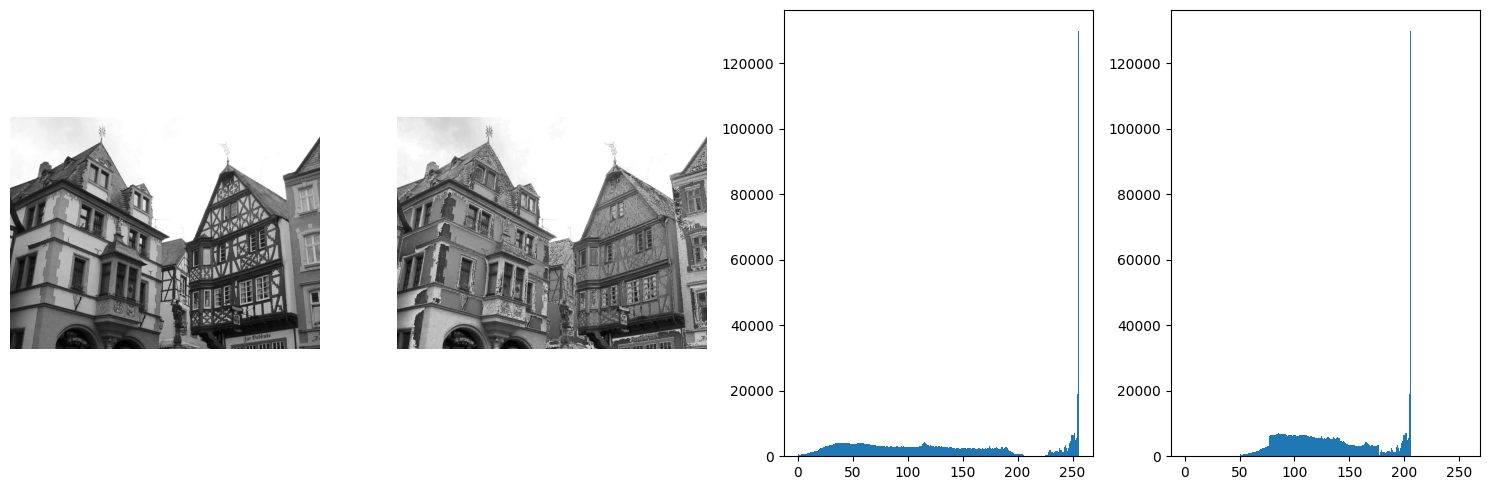

In [ ]:
fig, ax = pt.subplots(1,4, figsize=(15,5))
ax[0].imshow(img3, cmap='gray')
ax[0].axis('off')
ax[1].imshow(img_comp, cmap='gray')
ax[1].axis('off')
ax[2].stairs(counts, fill=True)
ax[3].stairs(counts_comp, fill=True)
fig.tight_layout()

### Mudando o contraste

In [ ]:
def contrast(img, mode):
    if mode == 'log':
        img = (np.log(1+img)/(np.log(1+img.max())))*255
    if mode == 'exp':
        img = img = (np.exp(img**1/(255/np.log(1+img.max())))-1)
    return img

In [ ]:
img_log = contrast(img, 'log')

In [ ]:
img_exp = contrast(img, 'exp')

(-0.5, 1023.5, 682.5, -0.5)

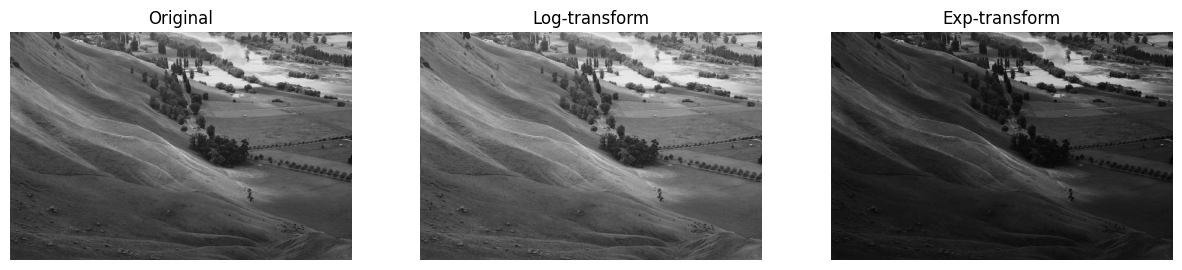

In [ ]:
fig, ax = pt.subplots(1,3, figsize=(15,10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(img_log, cmap='gray')
ax[1].set_title('Log-transform')
ax[2].imshow(img_exp, cmap='gray')
ax[2].set_title('Exp-transform')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

### Equalizando imagens com o pacote skimage



In [ ]:
from skimage import exposure

In [ ]:
def equalization(img):
    img_eq = np.copy(img)
    hist = histogram(img)
    h = np.nonzero(hist)[0] # cores com contagem nao zero
    cdf = np.cumsum(hist[np.nonzero(hist)])
    eq = np.round((cdf-cdf.min())/(img.size*cdf.min())*255)
    for col in range(h.size):
        for px in np.argwhere(img==h[col]):
            img_eq[px[0],px[1]] = eq[col]
    return img_eq

In [ ]:
img_eq = equalization(img)
img_eq_skm = exposure.equalize_hist(img)

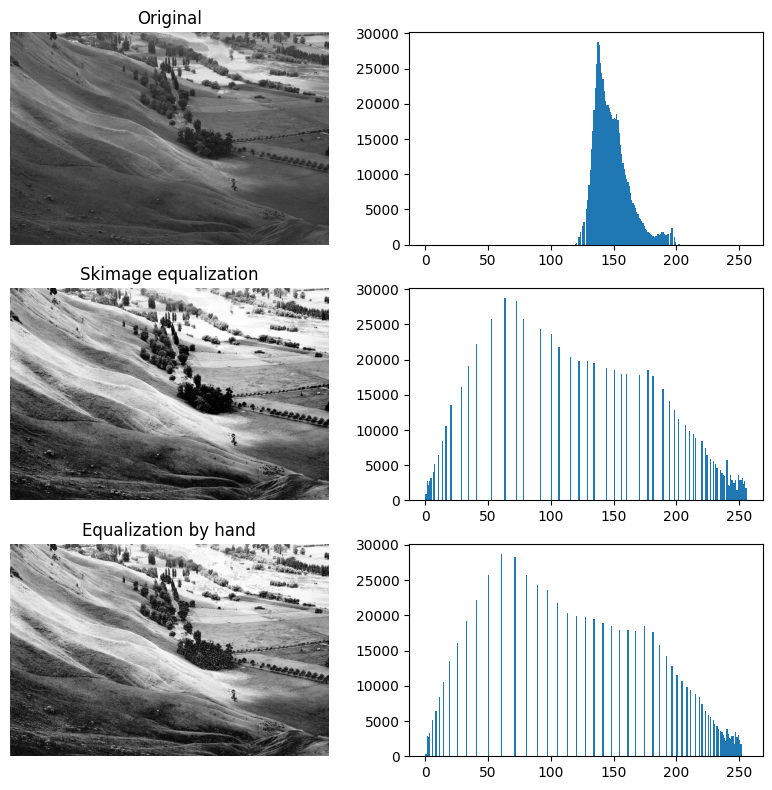

In [ ]:
fig, ax = pt.subplots(3,2, figsize=(8,8))
ax[0,0].imshow(img, cmap='gray')
ax[0,0].axis('off')
ax[0,0].set_title('Original')
ax[0,1].stairs(histogram(img), fill=True)
ax[1,0].imshow(img_eq_skm, cmap='gray')
ax[1,0].axis('off')
ax[1,0].set_title('Skimage equalization')
ax[1,1].stairs(histogram(np.round(img_eq_skm*255)), fill=True)
ax[2,0].imshow(img_eq, cmap='gray')
ax[2,0].axis('off')
ax[2,0].set_title('Equalization by hand')
ax[2,1].stairs(histogram(img_eq), fill=True)
fig.tight_layout()

### Usando diferentes tresholds a partir do pacote skimage

(-0.5, 1023.5, 767.5, -0.5)

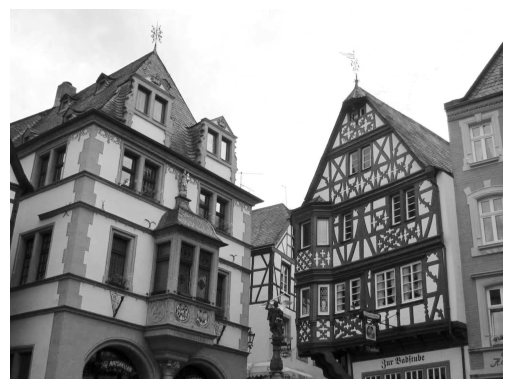

In [ ]:
pt.imshow(img3, cmap='gray')
pt.axis('off')

In [ ]:
from skimage.filters import threshold_otsu, threshold_mean

In [ ]:
def otsu_thresholding(img):
    img = img.flatten()
    hist = histogram(img)
    cdf = cdf_histogram(hist)
    mean_gray = np.mean(img)
    var = np.zeros_like(hist)

    for t in range(256):
        # computing class probability (background and foreground)
        pb = img[img<t].size
        wb = pb/img.size
        wf = 1-wb

        if wb != 0 and wb != 1:
            mb = np.sum(img[img<t])/pb
            mf = np.sum(img[img>=t])/(img.size-pb)

            vb = np.sum((img[img<t]-mb)**2)/pb
            vf = np.sum((img[img>=t]-mf)**2)/(img.size-pb)

        elif wb == 1:
            continue
        else:
            continue

        var[t] = wb*vb + wf*vf
    count = 0
    for v in var:
        if v != 0:
            break
        else:
            count+=1
        #print(wb,vb, wf,vf, var[t])
    threshold = np.argmin(var[np.nonzero(var)]) + count

    return threshold

In [ ]:
thd = otsu_thresholding(img)
otsu = threshold_otsu(img)

In [ ]:
img_otsu = img < thd
img_otsu_skm = img < otsu

Text(0.5, 1.0, 'Otsu skimage')

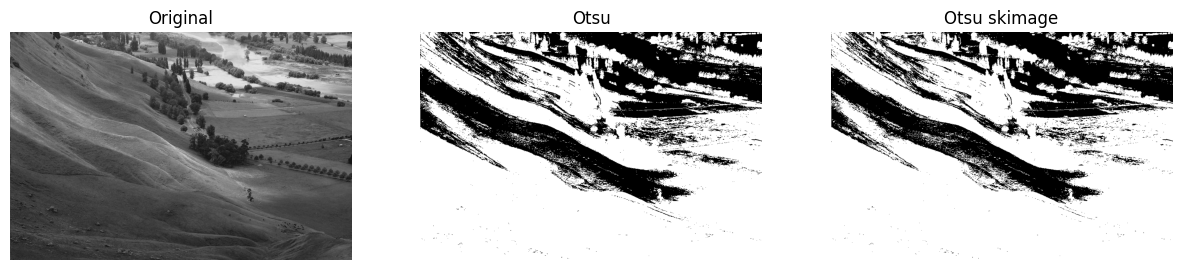

In [ ]:
fig, ax = pt.subplots(1,3, figsize=(15,10))
ax[0].imshow(img, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(img_otsu, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Otsu')
ax[2].imshow(img_otsu_skm, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Otsu skimage')